# Classification ignition point 

This project is a classification problem

It is to determine whether a point has a probability to be an ignition point for wildfire. The ignition point is where the wildfire starts. To know the probability where a fire would start is central at Descartes because it will help us to better simulate wildfires.

Don't hesitate to contact us, if you have any doubts on what is asked or if you encounter errors while using the notebook.

In [69]:
from pathlib import Path
import pandas as pd

#DG
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split

from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression

#import scipy as sp
#import sklearn as sk
pd.set_option('display.max_rows',500)
pd.set_option('display.max_columns',500)

In [71]:
%reload_ext autoreload
%autoreload 2

# Parameters

In [72]:
DATA_PATH = Path("data")
DATAFRAME_FOLDER_PATH = DATA_PATH / "classification_dataframe"

# Download data

In [73]:
dataframe_path = DATAFRAME_FOLDER_PATH / "dataset.csv"

In [74]:
df = pd.read_csv(dataframe_path, index_col=0)
print(df.head())
print(df.shape)
print(df.dtypes)
print(df.info())

         Date  distance_fire_stations  distance_rivers  distance_roads  \
0  2015-11-19            13287.682266      7211.102551     1250.000000   
1  2003-02-17             8721.381771      2358.495283      250.000000   
2  2012-02-26            10796.411441         0.000000     2015.564437   
3  2004-11-10             8253.787010       559.016994        0.000000   
4  2003-03-19             9905.806378         0.000000     1903.943276   

   distance_powerlines  cropland  forest_deciduous_broad  \
0         30196.233209       0.0                     0.0   
1         13768.169813       0.0                     0.0   
2          6254.998002       0.0                     0.0   
3         37350.535471       0.0                     0.0   
4          6427.480066       0.0                     0.0   

   forest_deciduous_needle  forest_evergreen_broad  forest_evergreen_needle  \
0                      0.0                1.000000                      0.0   
1                      0.0          

# Structure of the dataframe and Task


- Each row consists of an ignition or non-ignition point with the given features associated. The features were chosen as potentially influencing ignition.


- The last column named `ignition` says if the point was a real ignition point (meaning that it occurred historically), in that case the value is `1`. Otherwise, when the value is `0`, it means that it is a 'non-ignition point'.


- The columns `cropland` to `wetland` gives the ratio of each of the vegetation classes under which the ignition or non-ignition point lies. The sum of these ratios should be equal to 1. For more information refer to this website: https://lcviewer.vito.be/


- The temperatures should be in degrees celsius `(°C)`.


- The weather data come from different sources and they might have different units.

| Column name | Definition | Unit |
|--------|-----------|--------|
| `ignition`   | Target column| Boolean: {1,0} |
| `distance_{feature}` | Distance to nearest feature  |  Meters (m) |
| vegetation class: from `cropland` to `wetland`  |  Ratio of each of the vegetation classes  under which the ignition or non-ignition point lies    |  No unit (between 0 and 1)  |
| `aspect`  |  Orientation of the slope    |  Degrees (°)  |
| `elevation`  |  elevation value    |  Meters  |
| `slope`  |  Slope value    |  Degrees (°)  |
| `pop_dens`  |  Population density value    |  Persons per km2  |
| `max_temp`  |  Maximum temperature of the day    |  Degrees celsius (°C)  |
| `avg_temp`  |  Average temperature of the day   |  Degrees celsius (°C)  |
| `max_wind_vel`  |  Maximum wind velocity of the day    |  Meters per second (m/s)  |
| `avg_wind_angle`  |  Average angle of the vector wind over the day    |  Degrees (°)  |
| `avg_rel_hum`  |  Average relative humidity over the day    |  %  |
| `avg_soil`  |  Average soil moisture of the day    |  m3/m3  |
| `sum_prec`  |  Cumulative rainfall precipitation of the day    |  Millimeters (mm)  |
| `yearly_avg_temp`  |  Average temperature over the year    |  Degrees celsius (°C)  |
| `anom_{feature}`  |  Standardized anomaly of weather for the given day over the last 30 years. When the anomaly is positive, it means that the feature value is greater that the 30-year average    |  No unity |
| `forest`  |  Sum of all the columns where the names start with `forest`   |  No unit  |
| `vegetation_class`  |  Vegetation with the max occurrence in the vicinity of the ignition/non-ignition point    |  Without unit  |
| `Year`  |  Year of ignition    |  Without unit  |
| `max_max_temp`  |  Missing information    |  Missing information  |



# Task


🚨 **Your task is to design a classification algorithm to predict whether a point is an ignition point or not. The target column is `ignition`** 🚨

You can import any package you want.

In [8]:
# STEP 1: EXPLORING DATA 
# Idea here is to have a feeling of the data (types, na values, correlated variables), 
# to see how is the target variable (balanced or not)
# to cross this target variable with other variables (WARNING!! This was not easier for me to implement it here. To avoid losing time, I used excel sometimes because the dataset was not too heavier. Otherwise, I will have used R.  )
# In summary, having unidimensional and bidimensional analysis and cleaning our dataset

In [9]:
print(df.count())

target=df['ignition']
print(df.groupby('ignition').size)

Date                       22035
distance_fire_stations     22030
distance_rivers            22030
distance_roads             22030
distance_powerlines        22030
cropland                   22030
forest_deciduous_broad     22030
forest_deciduous_needle    22030
forest_evergreen_broad     22030
forest_evergreen_needle    22030
forest_mixed               22030
forest_unknown             22030
herbaceous_vegetation      22030
moss_lichen                22030
shrubland                  22030
sprarse_vegetation         22030
urban                      22030
water                      22030
wetland                    22030
aspect                     22035
elevation                  22035
pop_dens                   22035
slope                      22035
anom_max_temp              22035
anom_max_wind_vel          22035
anom_avg_temp              22035
anom_avg_rel_hum           22035
anom_avg_soil              22035
anom_sum_prec              22035
max_temp                   22035
max_wind_v

In [75]:
np.mean(target == 0)

# PERSONAL COMMENT : IMBALANCED CLASSES

0.8493306103925573

In [76]:
# Adding new time variables
# Since our target variable depends on the period year (more probable during hot months), interesting to have date information per weak, month and season
df['date_f']=pd.to_datetime(df['Date'])
df['Month']=df['date_f'].dt.month
df['Week']=df['date_f'].dt.isocalendar().week

df.loc[df['Month'].isin([9, 10, 11]), "season"]="Spring"
df.loc[df['Month'].isin([12, 1, 2]), "season"]="Summer"
df.loc[df['Month'].isin([3, 4, 5]), "season"]="Autumn"
df.loc[df['Month'].isin([6, 7, 8]), "season"]="Winter"


In [12]:
df.season

0        Spring
1        Summer
2        Summer
3        Spring
4        Autumn
          ...  
22030    Autumn
22031    Spring
22032    Winter
22033    Winter
22034    Summer
Name: season, Length: 22035, dtype: object

In [77]:
df.dtypes

Date                               object
distance_fire_stations            float64
distance_rivers                   float64
distance_roads                    float64
distance_powerlines               float64
cropland                          float64
forest_deciduous_broad            float64
forest_deciduous_needle           float64
forest_evergreen_broad            float64
forest_evergreen_needle           float64
forest_mixed                      float64
forest_unknown                    float64
herbaceous_vegetation             float64
moss_lichen                       float64
shrubland                         float64
sprarse_vegetation                float64
urban                             float64
water                             float64
wetland                           float64
aspect                            float64
elevation                         float64
pop_dens                          float64
slope                             float64
anom_max_temp                     

In [79]:
df.groupby('ignition').count()

,Date,distance_fire_stations,distance_rivers,distance_roads,distance_powerlines,cropland,forest_deciduous_broad,forest_deciduous_needle,forest_evergreen_broad,forest_evergreen_needle,forest_mixed,forest_unknown,herbaceous_vegetation,moss_lichen,shrubland,sprarse_vegetation,urban,water,wetland,aspect,elevation,pop_dens,slope,anom_max_temp,anom_max_wind_vel,anom_avg_temp,anom_avg_rel_hum,anom_avg_soil,anom_sum_prec,max_temp,max_wind_vel,avg_temp,avg_wind_angle,avg_rel_hum,avg_soil,sum_prec,forest,vegetation_class,Year,max_max_temp,yearly_avg_temp,date_f,Month,Week,season
ignition,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,18715,18710,18710,18710,18710,18710,18710,18710,18710,18710,18710,18710,18710,18710,18710,18710,18710,18710,18710,18715,18715,18715,18715,18715,18715,18715,18715,18715,18715,18715,18715,18715,18715,18715,18715,18715,18715,18683,18715,18715,12916,18715,18715,18715,18715
1,3320,3320,3320,3320,3320,3320,3320,3320,3320,3320,3320,3320,3320,3320,3320,3320,3320,3320,3320,3320,3320,3320,3320,3320,3320,3320,3320,3320,3320,3320,3320,3320,3320,3320,3320,3320,3320,3320,3320,3320,2288,3320,3320,3320,3320


In [80]:
print(df.describe())

       distance_fire_stations  distance_rivers  distance_roads  \
count            22030.000000     22030.000000    22030.000000   
mean             23646.387792      5966.777537     5152.597702   
std              19248.657525      7515.660146     6924.754655   
min                  0.000000         0.000000        0.000000   
25%               9568.829605       707.106781      250.000000   
50%              18494.931738      2610.076627     1581.138830   
75%              32310.988843      8384.323013     7941.190087   
max             110474.261708     43784.986011    40094.419811   

       distance_powerlines      cropland  forest_deciduous_broad  \
count         22030.000000  22030.000000            22030.000000   
mean          30127.951951      0.006415                0.013557   
std           30099.446768      0.057848                0.088239   
min               0.000000      0.000000                0.000000   
25%            8265.137627      0.000000                0.000000 

In [81]:
# Variables to suppress: 
# - All the variables which always have a constant value 
# - All variable which have a lot of missing values so that replacment doesn't seem a better option or can be recalculated with others (e.g: yearly_avg_temp )
#VarToSuppress=['forest_deciduous_needle', 'forest_mixed', 'moss_lichen']
VarToSuppress=['forest_deciduous_needle', 'forest_mixed', 'moss_lichen', 'yearly_avg_temp']

# List of Categorical variables
CatVar=['cropland','forest_deciduous_broad', 'urban', 'water', 'wetland','Month','Week','season','ignition']

# Creating subsets of dataset so that different analysis can be made 
df_new=df.drop(columns=VarToSuppress)
dfNumVar=df_new.drop(columns=CatVar)
dfCatVar=df_new[CatVar]

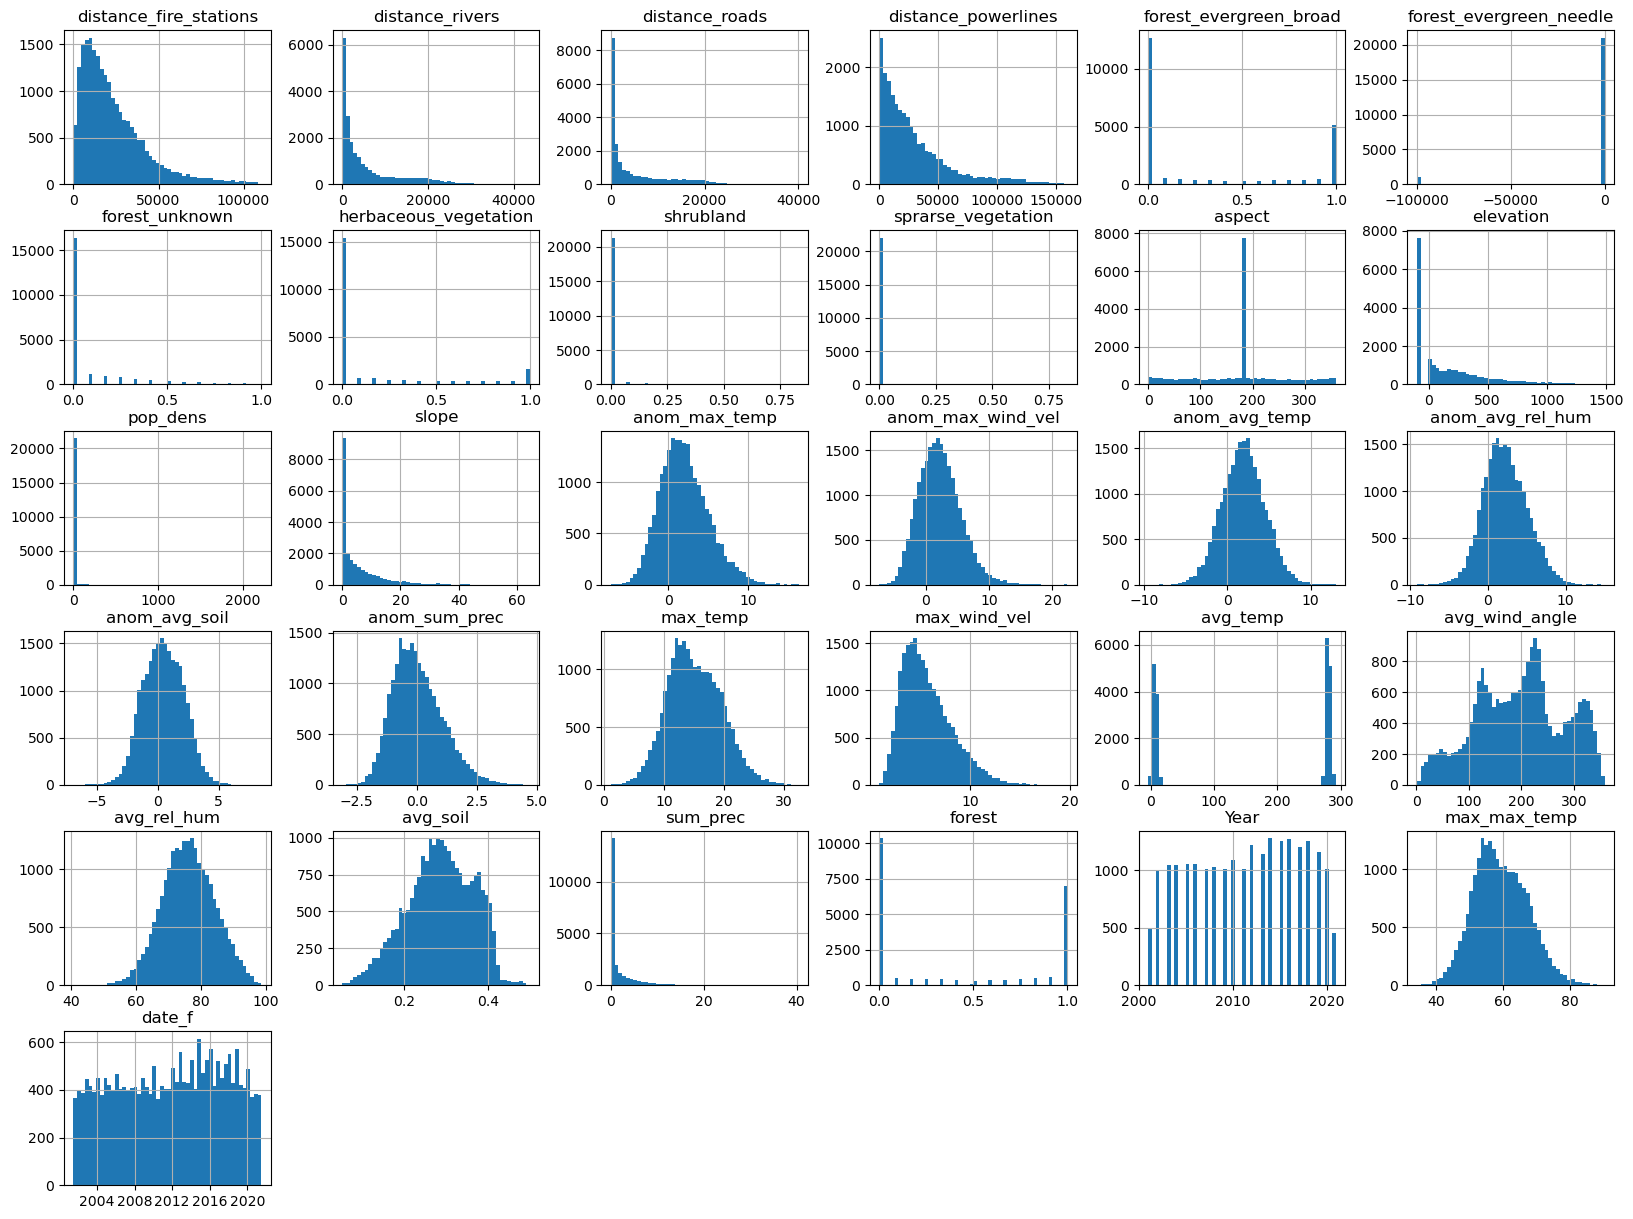

In [82]:
dfNumVar.hist(bins=50, figsize=(20, 15))
plt.show()
# COMMENTs: Year 2001 and 2021 seem to be incomplete

In [19]:
# scatter plot matrix
#pd.plotting.scatter_matrix(dfNumVar)
#plt.show()

dfNumVar.corr()

C:\Users\u005427\AppData\Local\Temp\ipykernel_9172\1616672874.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  dfNumVar.corr()


,distance_fire_stations,distance_rivers,distance_roads,distance_powerlines,forest_evergreen_broad,forest_evergreen_needle,forest_unknown,herbaceous_vegetation,shrubland,sprarse_vegetation,aspect,elevation,pop_dens,slope,anom_max_temp,anom_max_wind_vel,anom_avg_temp,anom_avg_rel_hum,anom_avg_soil,anom_sum_prec,max_temp,max_wind_vel,avg_temp,avg_wind_angle,avg_rel_hum,avg_soil,sum_prec,forest,Year,max_max_temp
distance_fire_stations,1.000000,0.380998,0.597202,0.361672,-0.157933,-0.002915,-0.182219,-0.078787,0.050097,0.008016,0.018039,-0.173331,-0.123523,-0.114441,-0.025922,-0.039148,-0.007638,0.094448,0.083319,0.027027,-0.104301,0.177206,-0.004632,-0.004945,0.114476,-0.141412,0.024765,-0.243551,-0.008939,-0.104301
distance_rivers,0.380998,1.000000,0.810262,0.511959,-0.393945,-0.002696,-0.246586,-0.300005,-0.086484,-0.010839,0.005710,-0.481924,-0.078922,-0.393058,-0.058853,-0.032854,-0.018274,0.004927,0.007498,0.011373,0.044370,0.405720,-0.001486,-0.065588,-0.101395,-0.293590,-0.285531,-0.491284,-0.007203,0.044370
distance_roads,0.597202,0.810262,1.000000,0.501996,-0.360746,-0.006670,-0.247274,-0.249587,-0.041647,-0.007702,0.018890,-0.424233,-0.086452,-0.318949,-0.044910,-0.037377,-0.015827,0.047852,0.047957,0.020795,-0.024913,0.346209,-0.005622,-0.042441,-0.018912,-0.255832,-0.185321,-0.461069,-0.010728,-0.024913
distance_powerlines,0.361672,0.511959,0.501996,1.000000,-0.338461,-0.001519,-0.216921,-0.154048,-0.042644,0.000480,0.017189,-0.434086,-0.104676,-0.290291,-0.041240,-0.030575,-0.011382,0.026771,0.014413,0.016358,0.014641,0.532158,-0.001569,-0.070887,-0.107333,-0.318020,-0.204134,-0.425787,-0.004821,0.014641
forest_evergreen_broad,-0.157933,-0.393945,-0.360746,-0.338461,1.000000,-0.006621,-0.125350,-0.340918,-0.078205,-0.011411,0.016578,0.446633,-0.043690,0.406767,0.020615,0.017171,0.013291,0.010601,0.003329,-0.007560,-0.037653,-0.326574,0.009935,0.037423,0.132318,0.300918,0.241640,0.883029,0.014015,-0.037653
forest_evergreen_needle,-0.002915,-0.002696,-0.006670,-0.001519,-0.006621,1.000000,-0.005376,0.007485,0.010388,0.003439,-0.004878,-0.002248,0.010032,0.001521,0.000777,-0.001246,-0.012368,-0.010279,-0.006019,-0.004959,0.005497,0.002094,-0.196420,0.001164,-0.017213,-0.007299,-0.003778,-0.007414,-0.335774,0.005497
forest_unknown,-0.182219,-0.246586,-0.247274,-0.216921,-0.125350,-0.005376,1.000000,0.036437,0.109307,-0.001877,-0.003348,0.246839,0.106620,0.113356,0.054728,0.014742,0.010149,-0.051893,-0.026765,-0.022194,0.012283,-0.169904,-0.001067,0.052317,-0.024074,0.086875,0.053755,0.313945,0.005237,0.012283
herbaceous_vegetation,-0.078787,-0.300005,-0.249587,-0.154048,-0.340918,0.007485,0.036437,1.000000,0.058753,0.010548,-0.020222,0.190920,0.002632,0.056123,0.024162,0.000895,0.002543,-0.007151,-0.006453,0.002234,-0.012504,-0.183795,-0.003971,0.036581,0.021387,0.063392,0.109559,-0.314575,0.001175,-0.012504
shrubland,0.050097,-0.086484,-0.041647,-0.042644,-0.078205,0.010388,0.109307,0.058753,1.000000,0.015301,-0.010196,0.085581,-0.004890,0.061435,0.014214,-0.006491,-0.002836,0.010741,0.011069,0.011224,-0.019987,-0.046616,-0.009244,0.007700,0.036206,0.027168,0.064425,-0.032436,-0.012184,-0.019987
sprarse_vegetation,0.008016,-0.010839,-0.007702,0.000480,-0.011411,0.003439,-0.001877,0.010548,0.015301,1.000000,-0.003181,-0.009400,-0.001770,-0.004627,-0.004650,-0.011651,0.003414,0.010322,-0.003232,-0.000174,0.001346,-0.003327,-0.000435,-0.002991,0.006917,-0.006511,0.000489,-0.012092,-0.002056,0.001346


C:\Users\u005427\AppData\Local\Temp\ipykernel_9172\1275489851.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(dfNumVar.corr(), annot=True, fmt='.2g', cmap='coolwarm')


<Axes: >

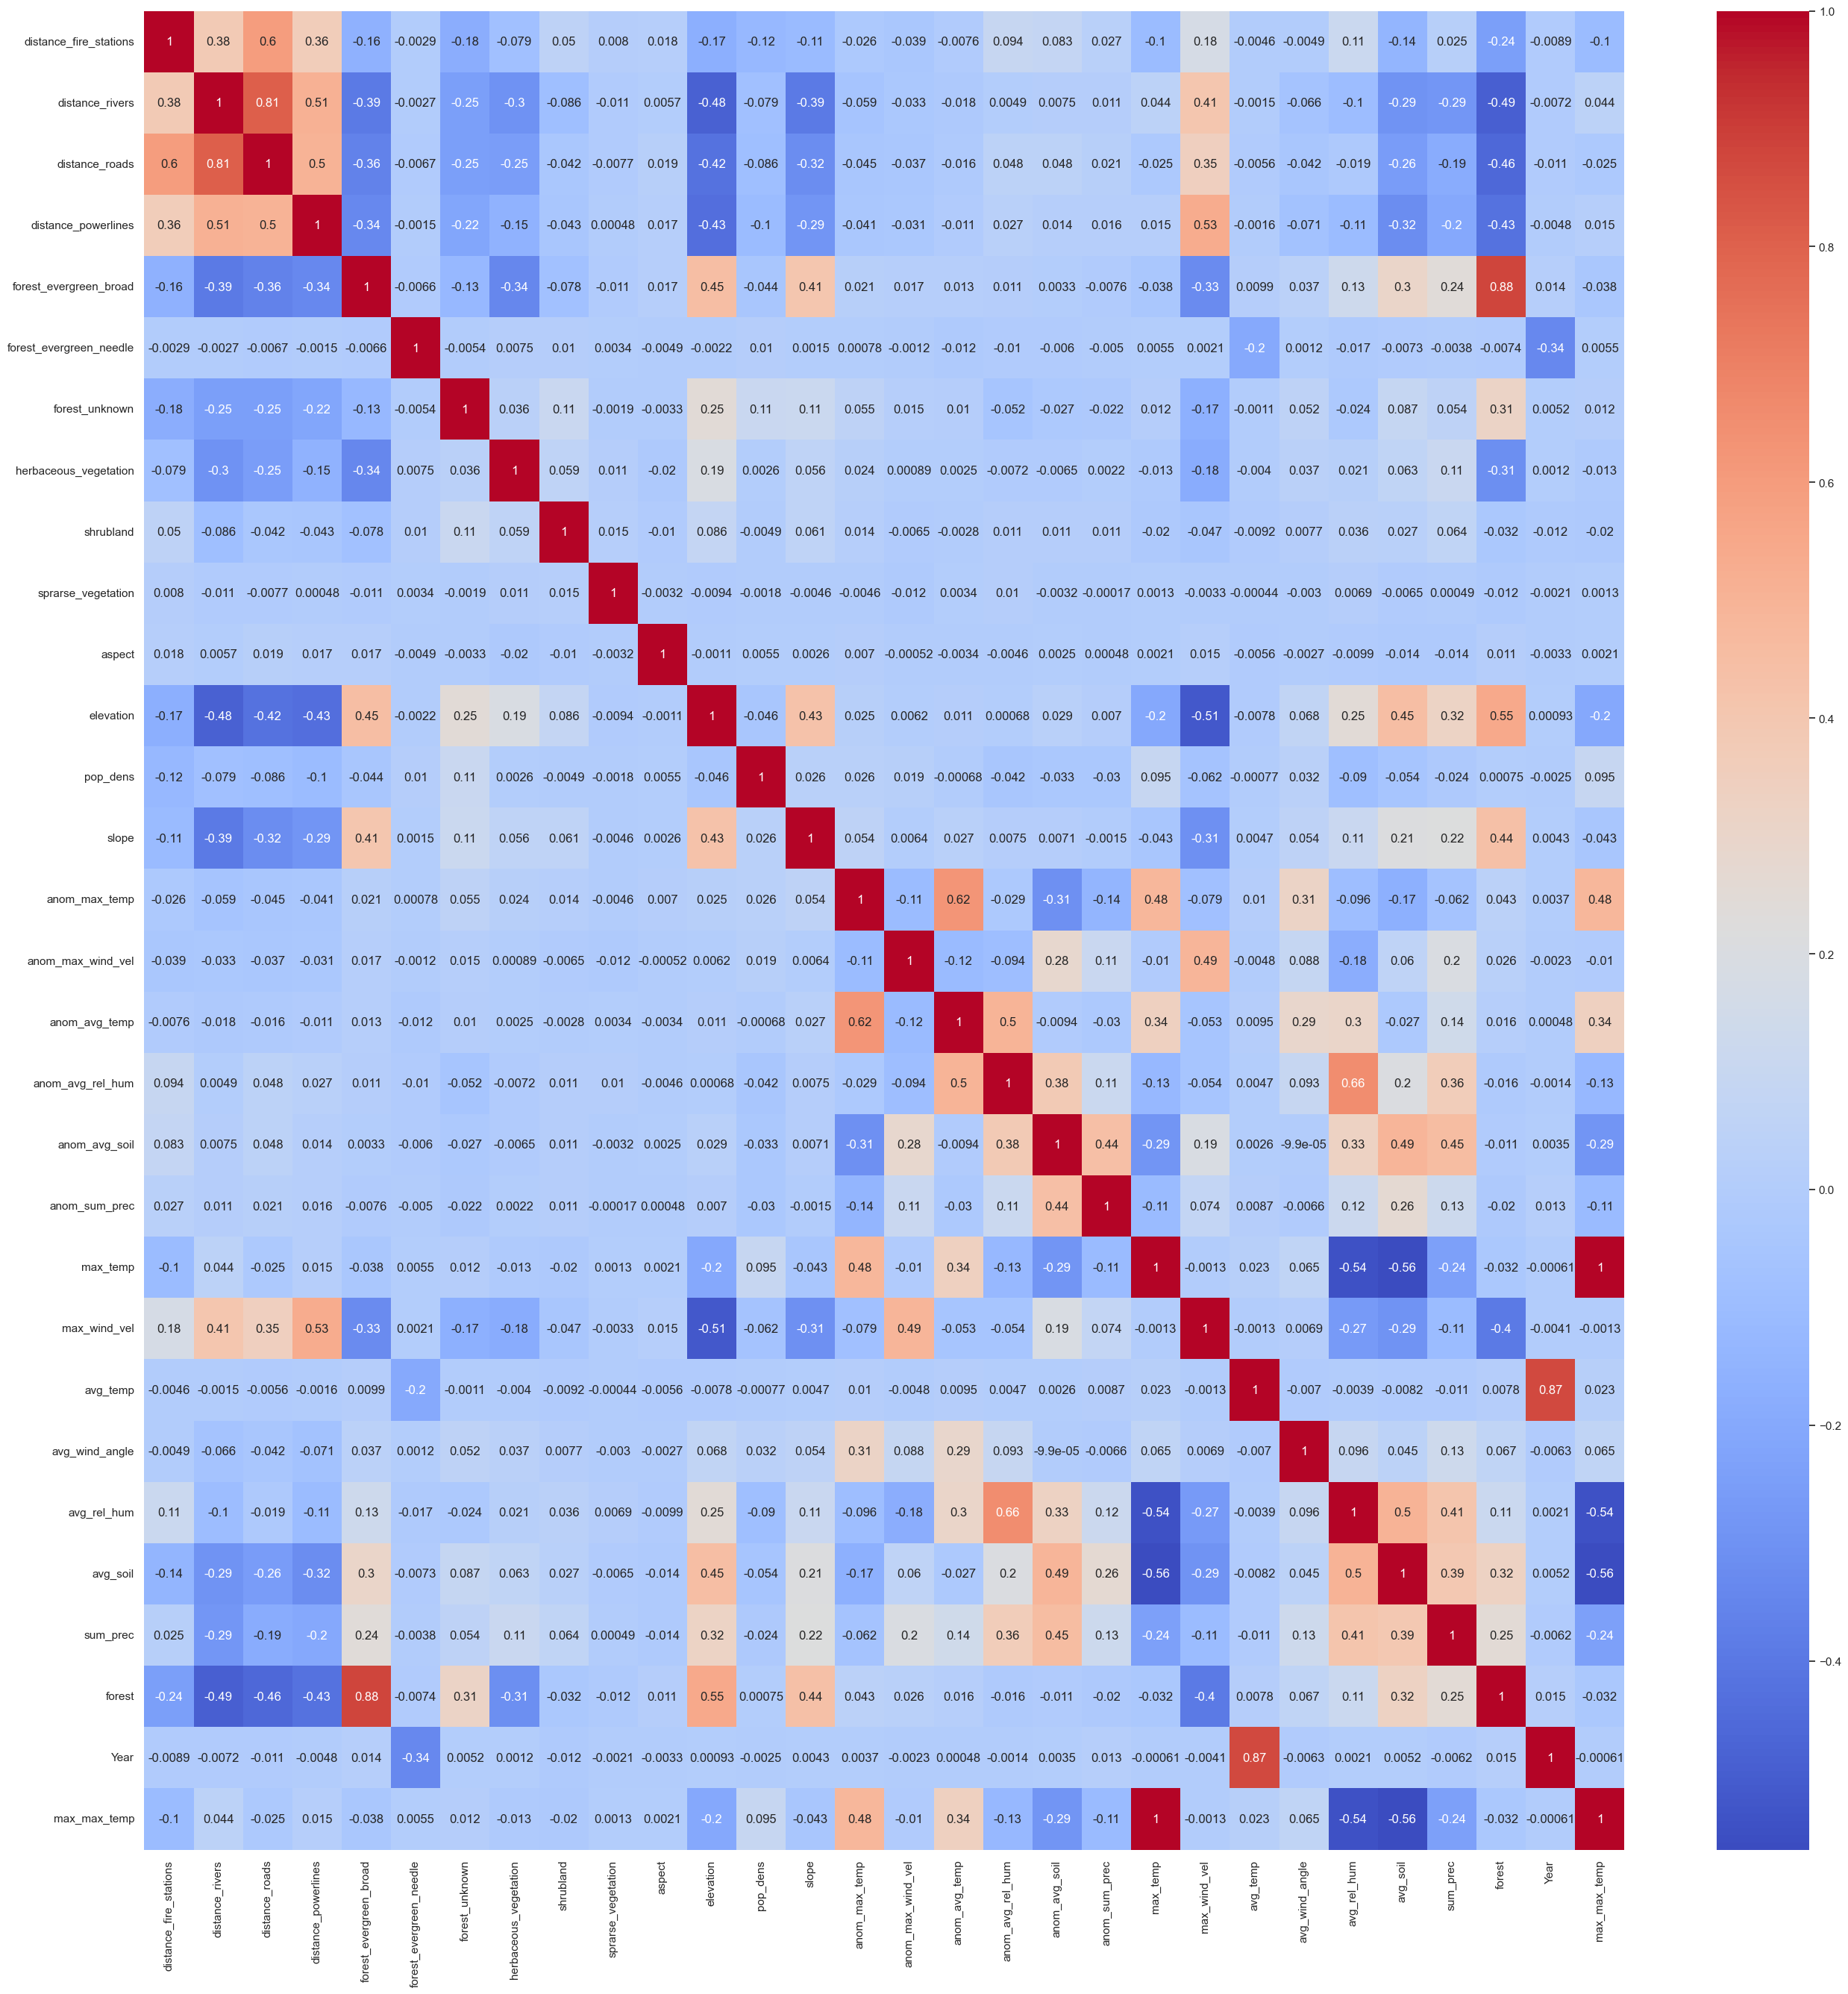

In [20]:
# scatter plot matrix / Betterfor visualisation of correlations
sns.set(rc={'figure.figsize':(32,32)})
sns.heatmap(dfNumVar.corr(), annot=True, fmt='.2g', cmap='coolwarm')

# Most correlated variables (with abs(Corr)>0.80): (distance_rivers and distance_road), (max_temp and max_max_temp), (Year and avg_temp), (forest and forest_evergreen_broad)
# Correlation between year and avg_temp tells that there is an increase of avg_temp with year
# tO DROP: distance_roads, max_max_temp (values are too high), forest_evergreen_broad

In [83]:
df_new=df_new.drop(columns=['distance_roads','max_max_temp','forest_evergreen_broad'])
dfNumVar=df_new.drop(columns=CatVar)

In [84]:
# --------------------------------------------------------------------------------------------------------------------
# This part should have been graphs on target variable and some explanatory variables but results not satisfying or too much time necessary to debug


In [23]:
# box and whisker plots
#dfCatVar.plot(kind='box', subplots=True, layout=(2,4))
#plt.show()

In [24]:
#dfCatVar.groupby(['ignition']).plot(kind='bar', sublayers=True)
#plt.show()

In [25]:
#dfCatVar.get(['season', 'ignition']).groupby('season').count().plot(kind='bar');

In [26]:
#sns.catplot(data=dfCatVar.loc[df['ignition']==0], x="season", y="ignition", hue="ignition", kind='bar')
#sns.catplot(data=dfCatVar, x="ignition", y="season", hue="ignition", kind='bar')

In [84]:

# --------------------------------------------------------------------------------------------------------------------


In [85]:
# We have 5 rows which have no values for many columns, there are just removed since there are not enough
# I prefer this solution instead of imputing any values
df_new2=df_new[~df_new.distance_rivers.isnull()]
df_new2.shape
#df_new2.isna()

(22030, 39)

In [86]:
list(df_new2)

['Date',
 'distance_fire_stations',
 'distance_rivers',
 'distance_powerlines',
 'cropland',
 'forest_deciduous_broad',
 'forest_evergreen_needle',
 'forest_unknown',
 'herbaceous_vegetation',
 'shrubland',
 'sprarse_vegetation',
 'urban',
 'water',
 'wetland',
 'aspect',
 'elevation',
 'pop_dens',
 'slope',
 'anom_max_temp',
 'anom_max_wind_vel',
 'anom_avg_temp',
 'anom_avg_rel_hum',
 'anom_avg_soil',
 'anom_sum_prec',
 'max_temp',
 'max_wind_vel',
 'avg_temp',
 'avg_wind_angle',
 'avg_rel_hum',
 'avg_soil',
 'sum_prec',
 'forest',
 'vegetation_class',
 'Year',
 'ignition',
 'date_f',
 'Month',
 'Week',
 'season']

In [87]:
# STEP 2 : PREPARING DATA FOR MACHINE LEARNING MODELS
# Idea here is to make all the preprocessing tasks like standardizing quantitative variables,
# transforming modalities of qualitive variables as dummies variables,
# keeping quantitative variables already with values between 0 & 1 (personal choice)

# Then, we split our data sets in train and test sets. Train for learning with models and test to evaluate.

In [88]:
# preprocessing data

# This variable 'forest_evergreen_needle' with values -10 000 and 1 will be transformed to stand between 0 and 1
df_new2['forest_evergreen_needle_std'] = (df_new2['forest_evergreen_needle'] - df_new2['forest_evergreen_needle'].min()) / (df_new2['forest_evergreen_needle'].max() - df_new2['forest_evergreen_needle'].min())

# Creating categorical and numerical variables

CatVar2=['vegetation_class','Month', 'season']

NumVar2=['distance_fire_stations','distance_rivers','distance_powerlines','aspect','elevation','pop_dens','slope','anom_max_temp',
         'anom_max_wind_vel','anom_avg_temp','anom_avg_rel_hum','anom_avg_soil','anom_sum_prec','max_temp','max_wind_vel',
         'avg_temp','avg_wind_angle','avg_rel_hum','sum_prec']

NumVar_0_1=['cropland','forest_deciduous_broad','forest_unknown','shrubland','sprarse_vegetation','urban',
            'wetland','avg_soil','forest','forest_evergreen_needle_std']

# ATTENTION!!!
#'water', 'herbaceous_vegetation': # These variables were in NumVar_0_1
# they are causing errors when running SVM Classification Model. Don't know why yet => Remove temporarily for now (this is not the solution, it is only to have my models showing results)


categorical_pipeline = make_pipeline(OneHotEncoder(handle_unknown='ignore'))
numerical_pipeline = make_pipeline(StandardScaler())

preprocessor = make_column_transformer(
    (categorical_pipeline, CatVar2),
    (numerical_pipeline, NumVar2)
)


C:\Users\u005427\AppData\Local\Temp\ipykernel_50320\2832566994.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new2['forest_evergreen_needle_std'] = (df_new2['forest_evergreen_needle'] - df_new2['forest_evergreen_needle'].min()) / (df_new2['forest_evergreen_needle'].max() - df_new2['forest_evergreen_needle'].min())


In [89]:
# Splitting our dataset between Y (as target variable) and X (explanatory variables)
y=df_new2['ignition']
X=df_new2[CatVar2+NumVar2+NumVar_0_1]

In [23]:
# Only to be run when this variable will be integrated again
#X
#X.water.describe()

In [27]:
# Creating train and test sets
# Since we have imbalanced classes, stratify option is used to allow for the same splitting of y in train and test sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=123, stratify=y)

In [91]:
# Applying transformation
X_transformed= preprocessor.fit_transform(X)

In [92]:
X_transformed

array([[ 0.        ,  0.        ,  1.        , ...,  0.33672369,
        -2.40056883, -0.40331722],
       [ 0.        ,  0.        ,  1.        , ...,  0.14396159,
        -1.86701858, -0.50862935],
       [ 0.        ,  0.        ,  1.        , ..., -1.45632466,
        -1.63075477, -0.50701372],
       ...,
       [ 0.        ,  0.        ,  1.        , ...,  1.32279274,
         0.34750326,  0.18137162],
       [ 0.        ,  0.        ,  0.        , ...,  1.26895   ,
         0.74290446, -0.51487508],
       [ 1.        ,  0.        ,  0.        , ..., -2.13557817,
        -0.03125912,  1.10110335]])

In [93]:
from sklearn.model_selection import train_test_split

# Creating train and test sets
# Since we have imbalanced classes, stratify option is used to allow for the same splitting of y in train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.20, random_state=123, stratify=y)

In [86]:
#X_train.water.describe()

count    17624.000000
mean         0.364389
std          0.474275
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: water, dtype: float64

In [94]:
print(np.mean(y_train==0))
print(np.mean(y_test==0))

0.8492964139809351
0.8492964139809351


In [95]:
preprocessor.get_feature_names_out

<bound method ColumnTransformer.get_feature_names_out of ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['vegetation_class', 'Month', 'season']),
                                ('pipeline-2',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler())]),
                                 ['distance_fire_stations', 'distance_rivers',
                                  'distance_powerlines', 'aspect', 'elevation',
                                  'pop_dens', 'slope', 'anom_max_temp',
                                  'anom_max_wind_vel', 'anom_avg_temp',
                                  'anom_avg_rel_hum', 'anom_avg_soil',
                                  'anom_sum_prec', 'max_temp', 'max_wind_vel',
                      

In [97]:
# STEP 3: LEARNING MODELS AND DISPLAYING PERFORMANCE MEASURES
# We are parameterizing models, let them run and calculating performance measures. 
# This step implies cross validation samples and tuning parameters whenever possible.
# As performance measures, we can have accuracy. We can use confusion matrix that to calculate precision, recall, F-score
# ROC curve or area under ROC can be used too
# One also needs to look at underfitting vs overfitting with learning curves

# COMMENT: We have seen before that the target variable is imbalanced. 
# (In this case, models will have the trend to predict the majority "class")
# In my search, it is recommended not to use classical methods instead of SVM Classification Model (with option balanced class)
# Random Forest also seems to work well
# Another option is to oversampling/ undersampling => SMOTE() in sklearn is an option for it
# Accuracy is not indicated as performance measure, one should privilege AUC ROC/ F1-SCORE / AUC Precision(?)

# In my case, I use more AUC ROC. I also performed a classical LogisticRegression on Imbalanced classes 
# to see how the "recommended" methods work. 

In [98]:
### WARNINGS: 
# Didn't have time to fine tuning parameters/ using Grid search
# making a table of performance measures to make comparisons easing between methods
# Looking at underfitting/overfitting
# I would have been happy to have the list of most important variables especially with random forest
# Couldn't make XGBoost model. I have the feeling it could have performed better than random forest. It would have been interesting to see. 

In [99]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

clf=LogisticRegression()

scores = cross_val_score(clf, X_train, y_train, cv=8, scoring='roc_auc')
print("scores LogReg:",scores)

clf.fit(X_train,y_train)
pred_y =clf.predict(X_test)

print("Accuracy LogReg:", accuracy_score(pred_y, y_test) )
print(np.unique( pred_y) )
print(np.count_nonzero(pred_y)/len(pred_y))

print("F1-Score LogReg:", f1_score(y_test, pred_y))
print("ROC AUC LogReg:", roc_auc_score(y_test, pred_y))

C:\Users\u005427\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\u005427\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_i

scores LogReg: [0.86940976 0.86325205 0.87367106 0.87530185 0.87016318 0.86364485
 0.8649746  0.86657641]
Accuracy LogReg: 0.8690422151611439
[0 1]
0.08102587380844303
F1-Score LogReg: 0.4348677766895201
ROC AUC LogReg: 0.6491301926036589


C:\Users\u005427\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [100]:
#### OPTION 1 (to deal with imbalanced classes): Use a SVC model with feature class_weight equals "balanced"

from sklearn.svm import SVC

######## TO DO : USE GRID SEARCH AND K FOLDS
# Train model
svc_clf = SVC(kernel='linear', 
            class_weight='balanced', # penalize
            probability=True)
 
#svc_scores = cross_val_score(svc_clf, X_train, y_train, cv=8, scoring='roc_auc')
#print(svc_scores)
svc_clf.fit(X_train, y_train)

# Predict on training set
pred_y_svc = svc_clf.predict(X_test)

print("Accuracy SVC:", accuracy_score(pred_y_svc, y_test) )
print( np.unique( pred_y_svc) )
print(np.count_nonzero(pred_y_svc)/len(pred_y_svc))

print("F1-Score SVC:", f1_score(y_test, pred_y_svc))
print("AUC ROC SVC: ",roc_auc_score(y_test, pred_y_svc))

Accuracy SVC: 0.7621425329096686
[0 1]
0.330458465728552
F1-Score SVC: 0.5056603773584906
AUC ROC SVC:  0.7806855428126187


In [101]:
##### OPTION 2 (to deal with imbalanced classes): Use Random forest

from sklearn.ensemble import RandomForestClassifier

rdf_clf = RandomForestClassifier(random_state=123)
rdf_scores = cross_val_score(rdf_clf, X_train, y_train, cv=8, scoring='roc_auc')
print("scores RF:", rdf_scores)

rdf_clf.fit(X_train, y_train)
 
# Predict on training set
pred_y_rdf = rdf_clf.predict(X_test)

print( "Accuracy RF:", accuracy_score(y_test, pred_y_rdf) )
print( np.unique( pred_y_rdf) )
print(np.count_nonzero(pred_y_rdf)/len(pred_y_rdf))

print("F1-Score RF:", f1_score(y_test, pred_y_rdf))
print("AUC ROC RF: ",roc_auc_score(y_test, pred_y_rdf))

scores RF: [0.92439292 0.92266635 0.91813057 0.92824693 0.91939672 0.91482633
 0.90803835 0.91599589]
Accuracy RF: 0.893781207444394
[0 1]
0.07943713118474807
F1-Score RF: 0.5384615384615384
AUC ROC RF:  0.6952836734431044


In [25]:
##### OPTION 3 (to deal with imbalanced classes): Use over sampling on the lowest class to have a balanced 

# importing library to oversampling minority class (SMOTE)
#%pip install imbalanced-learn
#import imblearn

Note: you may need to restart the kernel to use updated packages.


In [102]:
from imblearn.over_sampling import SMOTE, ADASYN

X_smote,y_smote=SMOTE().fit_resample(X_train,y_train)

In [103]:
len(y_smote)
print(y_smote.value_counts())

0    14968
1    14968
Name: ignition, dtype: int64


In [106]:
### Now our target variable isbalanced, use of SGD Classifier then Random Forest

from sklearn.linear_model import SGDClassifier

sgd_clf_over = SGDClassifier(max_iter=5, random_state=123)
sgd_clf_over.fit(X_smote, y_smote)

# Our database is bigger so more sets (16 instead of 8 before)
score_sgd_smote=cross_val_score(sgd_clf_over, X_smote, y_smote, cv=16, scoring='roc_auc')
print ("scores SGD:", score_sgd_smote)

pred_y_sgd =sgd_clf_over.predict(X_test)

print( "Accuracy SGD:", accuracy_score(pred_y_sgd, y_test) )
print( np.unique(pred_y_sgd) )
print(np.count_nonzero(pred_y_sgd)/len(pred_y_sgd))

print("F1-Score SGD:", f1_score(y_test, pred_y_sgd))
print("ROC AUC SGD:", roc_auc_score(y_test, pred_y_sgd))

C:\Users\u005427\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\u005427\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\u005427\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\u005427\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\u005427\Anaconda3\lib\site-packages\sklearn

scores SGD: [0.84510947 0.84338064 0.8307738  0.85997189 0.83738288 0.85748435
 0.8465492  0.85798026 0.86416198 0.8649367  0.85722382 0.84817976
 0.85281777 0.85690617 0.83757256 0.81925476]
Accuracy SGD: 0.7364956876985929
[0 1]
0.36972310485701315
F1-Score SGD: 0.49367640645442645
ROC AUC SGD: 0.7841684750761464


C:\Users\u005427\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\u005427\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\u005427\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\u005427\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\u005427\Anaconda3\lib\site-packages\sklearn

In [107]:
from sklearn.ensemble import RandomForestClassifier

rdf_clf_over = RandomForestClassifier(random_state=123)
rdf_scores_over = cross_val_score(rdf_clf_over, X_smote, y_smote, cv=16, scoring='roc_auc')
print("scores RF OVERSAMPLING:", rdf_scores_over)

rdf_clf_over.fit(X_smote, y_smote)
 
# Predict on training set
pred_y_rdf_over = rdf_clf_over.predict(X_test)

print("Accuracy RF OVERSAMPLING:",accuracy_score(y_test, pred_y_rdf_over) )
print( np.unique( pred_y_rdf_over) )

print(y_test.value_counts())
print(np.count_nonzero(pred_y_rdf_over)/len(pred_y_rdf_over))
print(np.mean(pred_y_rdf_over==0))

print("F1-Score RF OVERSAMPLING:", f1_score(y_test, pred_y_rdf_over))
print("ROC AUC RF OVERSAMPLING:", roc_auc_score(y_test, pred_y_rdf_over))

scores RF OVERSAMPLING: [0.95827163 0.95759804 0.95755576 0.99487465 0.9928116  0.991429
 0.99084282 0.99226941 0.99441759 0.99094508 0.99272076 0.99202546
 0.99318982 0.99295157 0.99318525 0.99363716]
Accuracy RF OVERSAMPLING: 0.8710848842487517
[0 1]
0    3742
1     664
Name: ignition, dtype: int64
0.1852019972764412
0.8147980027235587
F1-Score RF OVERSAMPLING: 0.6162162162162163
ROC AUC RF OVERSAMPLING: 0.7952708750555402


In [108]:
# Getting most important variables
#list_of_variables <- getSignificantVariables(rdf_clf_over, X_smote)
#list_of_variables